# Etude, mise en forme de la base sur les logements

L'enquête logement de l'Insee nous renseigne sur les données relatifs à l'habitation et à la population de chaque commune. En particulier une variable a attiré notre attention : P18_PMEN_ANEM0002 à savoir la population des ménages en 2018 ayant emménagé il y a moins de deux ans (entre 2016 et 2018) dans la commune. Ainsi, cette variable traduit selon nous en partie l'attractivité d'une commune par rapport à une autre. En effet, contrairement à la variable P18_MPEN qui donne la population totale des ménages, elle ne prends pas en compte l'accroissement naturelle de la population (à savoir les décès et les naissances). Nous chercherons donc par la suite à la prédire par des variables explicatives.

Dans ce notebook, nous étudirons ainsi les variables intéressantes du logement par rapport au sujet des mobilités résidentielles.

In [26]:
import pandas as pd
import xlrd 
import matplotlib.pyplot as plt
from math import log
import seaborn as sns
import numpy as np

In [12]:
#Importation de la base de données des logements
df_logement = pd.read_csv("./base-cc-logement-2018.csv", sep = ";", low_memory=False)

#Importation d'une table de correspondance pour avoir le nom des département avec leur chiffre
table_correspondance = pd.read_csv("./departements-francais.csv", sep  = "\t")[0:96]

table_correspondance

,NUMÉRO,NOM,REGION,CHEF LIEU,SUPERFICIE (km²),POPULATION,DENSITE (habitants/km2)
0,1,Ain,Auvergne-Rhône-Alpes,Bourg-en-Bresse,5762.0,631877.0,109.7
1,2,Aisne,Hauts-de-France,Laon,7369.0,538659.0,73.1
2,3,Allier,Auvergne-Rhône-Alpes,Moulins,7340.0,341613.0,46.5
3,4,Alpes-de-Haute-Provence,Provence-Alpes-Côte d'Azur,Digne,6925.0,161799.0,23.4
4,5,Hautes-Alpes,Provence-Alpes-Côte d'Azur,Gap,5549.0,140916.0,25.4
...,...,...,...,...,...,...,...
91,91,Essonne,Ile-de-France,Évry,1804.0,1276233.0,707.3
92,92,Hauts-de-Seine,Ile-de-France,Nanterre,176.0,1601569.0,9120.6
93,93,Seine-St-Denis,Ile-de-France,Bobigny,236.0,1592663.0,6742.9
94,94,Val-de-Marne,Ile-de-France,Créteil,245.0,1372389.0,5601.6


In [13]:
#On remanie la table de correspondance pour qu'elle puisse être fusionné par la suite
for i in range(len(table_correspondance)):
    if len(table_correspondance['NUMÉRO'][i])==1:
           table_correspondance['NUMÉRO'][i] = "0" + table_correspondance['NUMÉRO'][i]
            
table_correspondance = table_correspondance.rename(columns = {'NUMÉRO' : "DEP"})[["DEP",'NOM']]
table_correspondance

<ipython-input-13-f1dcaddf5e45>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table_correspondance['NUMÉRO'][i] = "0" + table_correspondance['NUMÉRO'][i]


,DEP,NOM
0,01,Ain
1,02,Aisne
2,03,Allier
3,04,Alpes-de-Haute-Provence
4,05,Hautes-Alpes
...,...,...
91,91,Essonne
92,92,Hauts-de-Seine
93,93,Seine-St-Denis
94,94,Val-de-Marne


In [14]:
#Création d'une nouvelle colonne 'DEP' pour pouvoir agréger les données par département
df_logement['DEP']=df_logement['CODGEO'].str[:2]

df = df_logement.groupby('DEP').sum().reset_index()

#Jointure pour les noms des départements
df = df.merge(table_correspondance ,how = "left").set_index('DEP')




In [15]:
df

,P18_LOG,P18_RP,P18_RSECOCC,P18_LOGVAC,P18_MAISON,P18_APPART,P18_RP_1P,P18_RP_2P,P18_RP_3P,P18_RP_4P,...,P08_RP_TTEGOU,P08_RP_GARL,P08_RP_VOIT1P,P08_RP_VOIT1,P08_RP_VOIT2P,P08_RP_HABFOR,P08_RP_CASE,P08_RP_MIBOIS,P08_RP_MIDUR,NOM
DEP,,,,,,,,,,,,,,,,,,,,,
01,317983.076447,274538.375368,17582.922701,25861.778379,201245.717768,114247.435494,7369.145461,25735.301722,49320.341418,73277.205828,...,0.0,175537.915132,210761.118146,103181.882498,107579.235648,0.0,0.0,0.0,0.0,Ain
02,266640.926339,231215.055899,9414.645126,26011.225313,201727.848075,62782.143121,5426.132009,17814.756456,40909.759309,62637.384661,...,0.0,133288.770854,180944.213815,105255.847843,75688.365972,0.0,0.0,0.0,0.0,Aisne
03,208375.028618,162853.779701,15038.175956,30483.072961,149707.029893,57168.325324,4538.240573,15284.093627,34794.731431,47364.829694,...,0.0,107064.756528,131920.892234,75173.272015,56747.620219,0.0,0.0,0.0,0.0,Allier
04,129062.084660,78089.671174,40196.730433,10775.683053,78587.926992,48992.409555,2653.180103,8345.656737,19159.524189,23502.575893,...,0.0,47595.950766,60650.533494,34254.425307,26396.108187,0.0,0.0,0.0,0.0,Alpes-de-Haute-Provence
05,136581.166248,66428.288308,62181.601413,7971.276526,58993.655160,76550.150769,2143.818712,7873.261326,15332.698099,18925.439755,...,0.0,41898.183005,51610.893626,29554.411525,22056.482101,0.0,0.0,0.0,0.0,Hautes-Alpes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,564587.450886,518768.016079,9242.110955,36577.323852,260614.004027,297014.686753,33363.396113,68994.580736,119133.047660,124879.070368,...,0.0,327715.452592,392658.680898,227047.527141,165611.153757,0.0,0.0,0.0,0.0,Essonne
92,801736.785972,719924.794049,29878.111326,51933.880597,90617.111459,699698.238069,91622.205146,171441.051621,209382.984122,140825.400491,...,0.0,363097.848866,465747.042765,352346.106814,113400.935951,0.0,0.0,0.0,0.0,Hauts-de-Seine
93,679663.108067,632024.931575,7492.635497,40145.540996,160062.858188,507011.480412,65331.658362,138331.565395,195887.555798,141065.086145,...,0.0,282635.020367,368495.422234,279099.757422,89395.664812,0.0,0.0,0.0,0.0,Seine-St-Denis


In [16]:
#Exportations des résultats
df[["P18_PMEN", "NOM"]].to_csv(r"./Pop_dep_2018.csv")
df[["P18_PMEN_ANEM0002", "NOM"]].to_csv(r'./Nb_arrive_16-18.csv')

# Statistiques descriptives sur les données de logements

## 1. Dynamisme de la population

On peut observer la part de la population des ménages en 2018 qui est arrivé il y a moins de 2ans sur la population totale des ménages. Une part forte serait révélateur d'un fort dynamisme du département soit parce que beaucoup quitte le département soit parce que beaucoup y aménage relativement à la population.



In [17]:
df_PROP_MEN = df[["P18_PMEN", "P18_PMEN_ANEM0002", "P18_PMEN_ANEM0204", "P18_PMEN_ANEM0509", "P18_PMEN_ANEM10P","NOM"]]

df_PROP_MEN["P18_PMEN_PROP_0002"] = df_PROP_MEN["P18_PMEN_ANEM0002"]/df_PROP_MEN["P18_PMEN"]*100
df_PROP_MEN["P18_PMEN_PROP_0204"] = df_PROP_MEN["P18_PMEN_ANEM0204"]/df_PROP_MEN["P18_PMEN"]*100
df_PROP_MEN["P18_PMEN_PROP_0509"] = df_PROP_MEN["P18_PMEN_ANEM0509"]/df_PROP_MEN["P18_PMEN"]*100
df_PROP_MEN["P18_PMEN_PROP_10P"] = df_PROP_MEN["P18_PMEN_ANEM10P"]/df_PROP_MEN["P18_PMEN"]*100



<ipython-input-17-163401b85fab>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_PROP_MEN["P18_PMEN_PROP_0002"] = df_PROP_MEN["P18_PMEN_ANEM0002"]/df_PROP_MEN["P18_PMEN"]*100
<ipython-input-17-163401b85fab>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_PROP_MEN["P18_PMEN_PROP_0204"] = df_PROP_MEN["P18_PMEN_ANEM0204"]/df_PROP_MEN["P18_PMEN"]*100
<ipython-input-17-163401b85fab>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

,P18_PMEN,P18_PMEN_ANEM0002,P18_PMEN_ANEM0204,P18_PMEN_ANEM0509,P18_PMEN_ANEM10P,NOM,P18_PMEN_PROP_0002,P18_PMEN_PROP_0204,P18_PMEN_PROP_0509,P18_PMEN_PROP_10P
DEP,,,,,,,,,,
31,1.353697e+06,203338.862444,328033.727629,262582.122338,559742.628904,Haute-Garonne,15.020999,24.232428,19.397403,41.349171
34,1.134713e+06,167715.198139,271334.733272,221236.995018,474426.508723,Hérault,14.780401,23.912181,19.497169,41.810249
69,2.320613e+06,326952.414165,584590.398490,472875.148206,936194.795400,Rhône,14.089055,25.191209,20.377167,40.342569
66,4.661924e+05,65606.456009,102896.087002,91058.571225,206631.314564,Pyrénées-Orientales,14.072827,22.071591,19.532400,44.323181
11,3.639274e+05,49943.647362,77245.853660,69700.895384,167037.030507,Aude,13.723518,21.225620,19.152416,45.898445


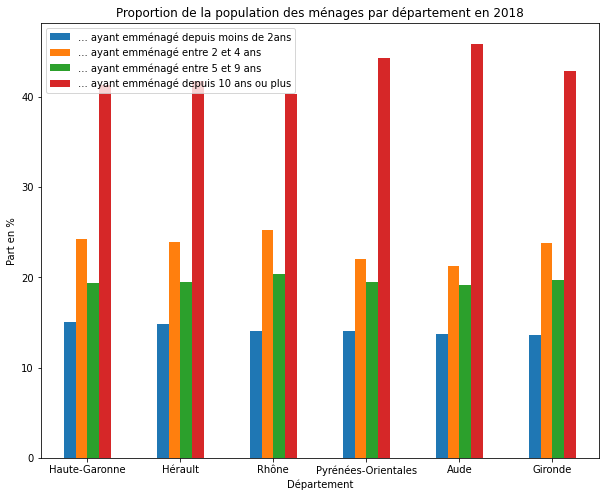

In [18]:
df_PROP_MEN_5P = df_PROP_MEN.sort_values("P18_PMEN_PROP_0002", ascending = False).head(6)[["P18_PMEN_PROP_0002", "P18_PMEN_PROP_0204", "P18_PMEN_PROP_0509", "P18_PMEN_PROP_10P"]] 
df_PROP_MEN_5P.columns = ["... ayant emménagé depuis moins de 2ans", "... ayant emménagé entre 2 et 4 ans", "... ayant emménagé entre 5 et 9 ans", "... ayant emménagé depuis 10 ans ou plus"]
legend = df_PROP_MEN.sort_values("P18_PMEN_PROP_0002", ascending = False).head(6)['NOM']
ax  = df_PROP_MEN_5P.plot(kind = "bar")
fig = ax.get_figure()
# Change the plot dimensions (width, height)
fig.set_size_inches(10, 8)

# Change the axes labels
ax.set_xlabel("Département")
ax.set_ylabel("Part en %")
ax.xaxis.set_ticklabels(legend)
plt.xticks(rotation = 'horizontal')
plt.title("Proportion de la population des ménages par département en 2018")
plt.show()


A priori les département de Haute-Garonne, Hérault, Rhône, Pyrénées-Orientales,Aude et Gironde ont le plus attiré le plus de personnes entre 2016 et 2018 comparativement à leur population. 

Sur une carte il s'agit de département située dans le sud du pays (Haute-Garonne, Hérault, Pyrénées-Orientales et Aude sont tous situés au niveau des Pyrénées) et plutôt vers de grosses agglomérations (Toulouse pour la Haute-Garonne, Lyon pour le Rhône).

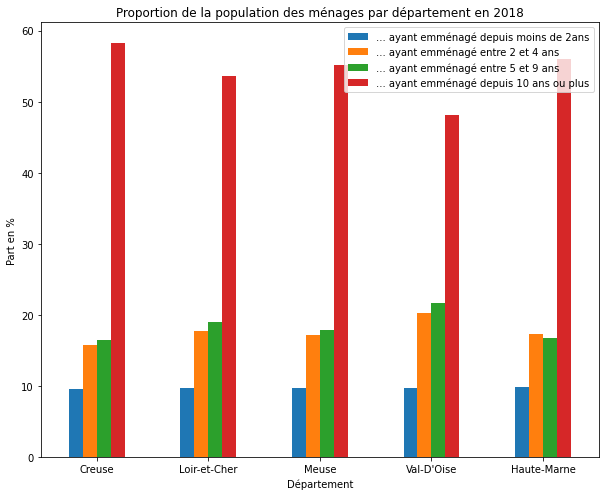

In [10]:
df_PROP_MEN_5D = df_PROP_MEN.sort_values("P18_PMEN_PROP_0002").head()[["P18_PMEN_PROP_0002", "P18_PMEN_PROP_0204", "P18_PMEN_PROP_0509", "P18_PMEN_PROP_10P"]] 
df_PROP_MEN_5D.columns = ["... ayant emménagé depuis moins de 2ans", "... ayant emménagé entre 2 et 4 ans", "... ayant emménagé entre 5 et 9 ans", "... ayant emménagé depuis 10 ans ou plus"]
legend = df_PROP_MEN.sort_values("P18_PMEN_PROP_0002").head()["NOM"]
ax  = df_PROP_MEN_5D.plot(kind = "bar")
fig = ax.get_figure()
# Change the plot dimensions (width, height)
fig.set_size_inches(10, 8)
# Change the axes labels
ax.set_xlabel("Département")
ax.xaxis.set_ticklabels(legend)
ax.set_ylabel("Part en %")
plt.xticks(rotation = 'horizontal')
plt.title("Proportion de la population des ménages par département en 2018")
plt.show()

A l'inverse 

Text(0.5, 1.0, 'boxplot avec sequence')

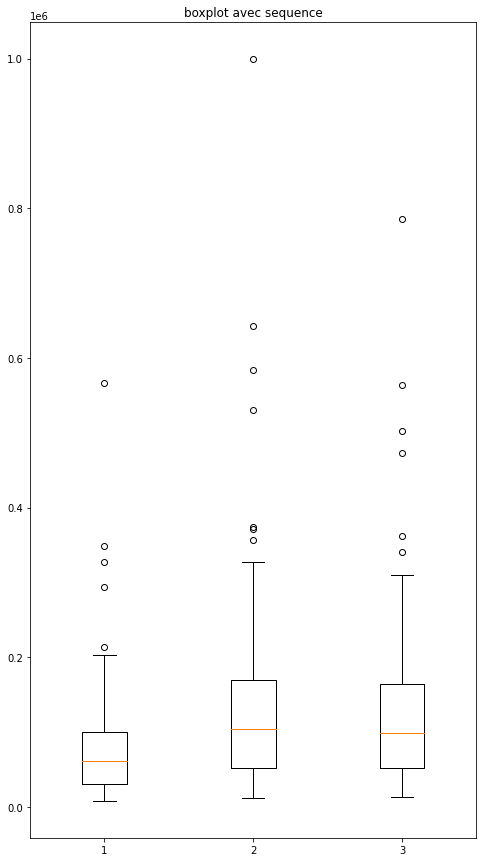

In [38]:
fig = plt.figure(figsize=(8,15))
ax = fig.add_subplot(111)
ax.boxplot([df["P18_PMEN_ANEM0002"], df["P18_PMEN_ANEM0204"], df["P18_PMEN_ANEM0509"] ])
plt.title('boxplot avec sequence')

In [32]:
df["P18_PMEN_ANEM0002"]

DEP
01     73410.587500
02     55966.273088
03     34727.220529
04     20764.972228
05     17542.794466
          ...      
91    132653.401354
92    177840.637209
93    160197.495479
94    143361.970814
95    119039.309196
Name: P18_PMEN_ANEM0002, Length: 96, dtype: float64

## En valeur absolue quelle département attire le plus de ménages ces deux dernières années